In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types for Measurement class
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types for Station class
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Precipitation Analysis - Last 12 Months

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Check row count
session.query(Measurement.prcp).count()

19550

In [14]:
# Check columns of the first 5 rows
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [15]:
# Calculate the date 1 year ago from the last data point in the database
# Last point in database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [16]:
# Date one year ago from last date in database
last_year_prcp = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year_prcp

datetime.date(2016, 8, 23)

In [17]:
# Query to retrieve last 12 months of precipitation data
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year_prcp).filter(
        Measurement.prcp != None).order_by(Measurement.date).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data).set_index('date')
prcp_df.sort_index()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


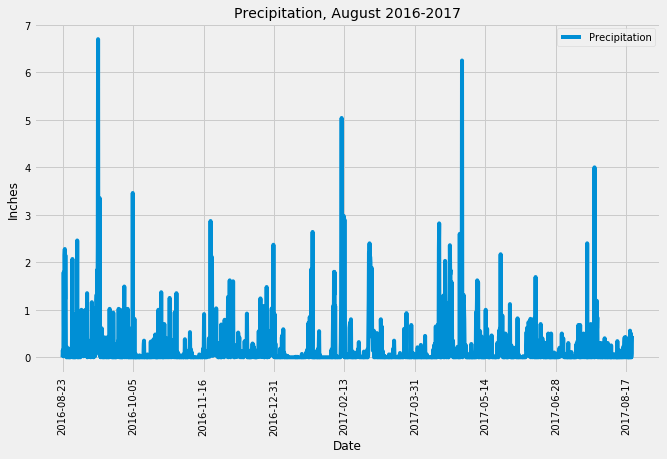

In [19]:
# Use Pandas with Matplotlib to plot the data
prcp_df.plot(rot=90, figsize=(10,6), fontsize=10)
plt.title("Precipitation, August 2016-2017", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.legend(["Precipitation"], fontsize=10)
plt.show()


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df[['prcp']].describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [21]:
# Design a query to show how many stations are available in this dataset (with raw SQL)
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [22]:
# Design a query to show how many stations are available in this dataset (with SQLAlchemy expression)
stations_list = session.query(Station.station, Station.name).all()
print(stations_list)
print(f"---------------------------------------------------------------------------------")
number_of_stations = session.query(Station.station).group_by(Station.station).count()
print(f"{number_of_stations} stations are available in this dataset.")

[('USC00519397', 'WAIKIKI 717.2, HI US'), ('USC00513117', 'KANEOHE 838.1, HI US'), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'), ('USC00517948', 'PEARL CITY, HI US'), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'), ('USC00519281', 'WAIHEE 837.5, HI US'), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]
---------------------------------------------------------------------------------
9 stations are available in this dataset.


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(
    Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station

# Station USC00519281 is the most active station - min, max, average temps recorded
station_summary = session.query(Measurement.station, func.min(Measurement.tobs), func.max(
    Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
station_summary

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get last date recorded for station USC00519281
last_date_USC00519281 = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(
    Measurement.date.desc()).first()
last_date_USC00519281

('2017-08-18')

In [26]:
# Then get one year from last recorded date to get the last 12 months of temperature observations
year_temp = dt.date(2017, 8, 18) - dt.timedelta(days=365)
year_temp

datetime.date(2016, 8, 18)

In [27]:
# Query the temperature for the last 12 months for station USC00519281
temp_data = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.date >= year_temp).filter(Measurement.station == 'USC00519281').all()

In [28]:
# Create a dataframe
temp_df = pd.DataFrame(temp_data)
temp_df.head()

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


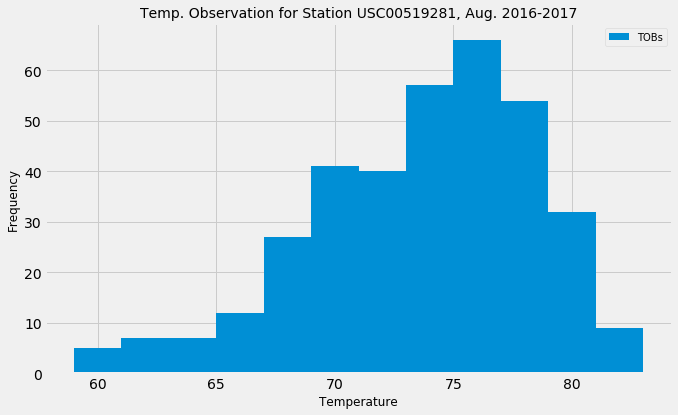

In [29]:
# Plot results as a histogram
temp_df.hist(column="tobs", bins=12, label="TOBs", figsize=(10,6))
plt.title("Temp. Observation for Station USC00519281, Aug. 2016-2017", fontsize=14)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis 1

In [30]:
# Identify the average temperature in June at all stations across all available years in the dataset.
june_date_str = "06"
june_avg_temp = session.query(func.avg(Measurement.tobs)).filter(
    func.strftime("%m", Measurement.date) == june_date_str).all()
print(f"The average temperature for the month of June is {june_avg_temp}")

The average temperature for the month of June is [(74.94411764705882,)]


In [31]:
# Do the same for December temperature.
dec_date_str = "12"
dec_avg_temp = session.query(func.avg(Measurement.tobs)).filter(
    func.strftime("%m", Measurement.date) == dec_date_str).all()
print(f"The average temperature for the month of December is {dec_avg_temp}")

The average temperature for the month of December is [(71.04152933421226,)]


In [32]:
# Get all June temperatures
june_date_str = "06"
june_temps = session.query(Measurement.tobs).filter(
    func.strftime("%m", Measurement.date) == june_date_str).all()

In [33]:
# Get all December temperatures
dec_date_str = "12"
dec_temps = session.query(Measurement.tobs).filter(
    func.strftime("%m", Measurement.date) == dec_date_str).all()

In [34]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?
stats.ttest_ind(june_temps, dec_temps)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

#### I used the unpaired t-test because I am comparing the means of two different groups of data (June temperatures vs December temperatures. The p-value of 3.9025129e-191 indicates that the difference in means between June and December temperatures are statistically significant. 

### Temperature Analysis 2 

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [36]:
# Use previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My trip dates: July 25, 2020 - August 7, 2020
print(calc_temps('2017-07-25', '2017-08-05'))

[(72.0, 78.93846153846154, 84.0)]


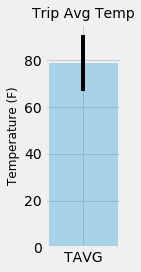

In [37]:
# Plot the results from previous query as a bar chart. 
# Use "Trip Avg Temp" as Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = ['TAVG']
y = [78.93846153846154]
error = [84-72]
fig, ax = plt.subplots(figsize=(2, 4))
ax.bar(x, y, yerr=error, alpha=0.3, ecolor='black')
ax.set_title('Trip Avg Temp', fontsize=14)
ax.set_ylabel('Temperature (F)', fontsize=12)
plt.tight_layout()
plt.show()


In [38]:
# Calculate the total amount of rainfall per weather station for trip dates using the previous year's 
# matching dates. Sort this in descending order by precipitation amount and list the station, name, latitude, 
# longitude, and elevation
session.query(func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude,\
            Station.longitude, Station.elevation).filter(
            Measurement.station == Station.station).filter(
            Measurement.date >='2017-07-25', Measurement.date <='2017-08-05').\
            group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[(1.9100000000000001,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (0.6199999999999999,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.52,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (0.28, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (0.05,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.04, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.01, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]